In [1]:
!pip install yfinance as yfinance

ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as


In [7]:
!pip install tensorflow

  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached termcolor-2.4.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached tensorboard-2.17.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached keras-3.4.1-py3-none-any.whl.metadata (5.8 kB)
  Using cached namex-0.0.8-py3-none-any.whl.metadata (246 bytes)
     ---------------------------------------- 0.0/48.7 kB ? eta -:--:--
     ---------------------------------------- 48.7/48.7 kB 1.2 MB/s eta 0:00:00
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
   ---------------

In [9]:
!pip install keras

In [11]:
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import datetime
from datetime import date, timedelta
import seaborn as sns
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN, LSTM, GRU
from keras.layers import Dropout
from keras.layers import *

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


%matplotlib inline

In [45]:
start_date=input("Enter the start date in format YYYY-MM-DD")
end_date=input("Enter the end date in format YYYY-MM-DD")

Enter the start date in format YYYY-MM-DD 2010-01-01
Enter the end date in format YYYY-MM-DD 2024-01-01


In [49]:
#2010-01-01
#2024-01-01
azn_df = yf.download("AZN.L", start=start_date, end=end_date)[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)

[*********************100%%**********************]  1 of 1 completed


In [51]:
azn_df

,Adj Close,Open,High,Low,Close,Volume
Date,,,,,,
2010-01-04,1627.21,2912.0,2946.0,2912.0,2941.0,2091679
2010-01-05,1608.67,2936.0,2949.5,2901.0,2907.5,2869739
2010-01-06,1590.69,2909.0,2909.0,2850.5,2875.0,3136541
2010-01-07,1610.33,2879.0,2925.5,2879.0,2910.5,3748200
2010-01-08,1609.23,2921.0,2927.5,2889.5,2908.5,2473846
...,...,...,...,...,...,...
2023-12-21,10318.16,10436.0,10552.0,10368.0,10480.0,2224399
2023-12-22,10274.84,10350.0,10454.0,10350.0,10436.0,651734
2023-12-27,10365.42,10472.0,10622.0,10428.0,10528.0,1044256


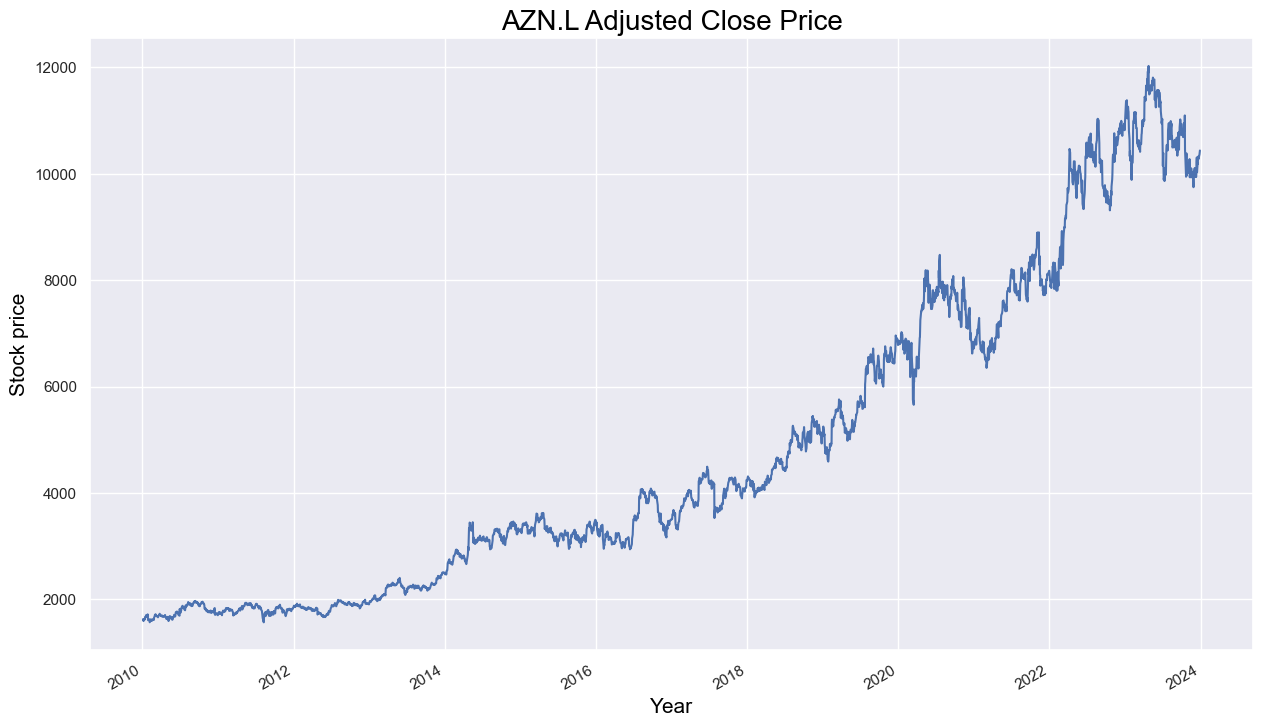

In [53]:
# Plot Adjusted Close price

azn_df['Adj Close'].plot(grid = True)
sns.set(rc={'figure.figsize':(15, 9)})
plt.title('AZN.L Adjusted Close Price', color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock price', color = 'black', fontsize = 15);

In [122]:
# standardise data to train model - only the training data are used to fit the scaler transformation
# then the scaler is used to transform the test input data

def ts_train_test(data,time_steps,for_periods):
    '''
    Create training and test sets, scale data

    :param data: dataframe with dates and price data
    :param time_steps: number of input time steps
    :param for_periods: number of output time steps

    :returns: X_train, y_train: data from 2010-2016
              X_test:  data from 2017-2020
              sc: instantiated MinMaxScaler object fit to the training data
    '''
    # Create training and test set
    ts_train = azn_df[:'2016'].iloc[:,0:1].values
    ts_test  = azn_df['2017':].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # Feature scaling - data normalisation - only the training data are used to fit the scaler transformation
    # MinMaxScaler scales all the data to be between 0 and 1.
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)

    # Create training data of samples and time steps
    X_train = []
    y_train = []
    for i in range(time_steps,ts_train_len-1): 
        X_train.append(ts_train_scaled[i-time_steps:i,0])
        y_train.append(ts_train_scaled[i:i+for_periods,0])
    # Convert X_train and y_train to numpy arrays for training
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train to 3-D array of samples, time steps and features for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    # Preparing to create X_test
    inputs = pd.concat((azn_df["Adj Close"][:'2016'], azn_df["Adj Close"]['2017':]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs  = sc.transform(inputs)

    # Creating X_test
    X_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])

    # Convert X_test to numpy array    
    X_test = np.array(X_test)

    #Added new line here
    
    '''# Reshape X_test to be 3-D
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    return X_train, y_train, X_test, sc'''



 # Reshape X_test to be 3-D# Convert the 3-D shape of X_train and y_train to a data frame 
X_train_df = pd.DataFrame(np.reshape(X_train, (X_train.shape[0],X_train.shape[1])))
y_train_df = pd.DataFrame(y_train)
pd.concat([X_train_df,y_train_df],axis=1)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test, sc



X_train, y_train, X_test, sc = ts_train_test(azn_df,5,2) # Each sample row in X_train has 5 inputs and y_train has 2 outputs
X_train.shape[0],X_train.shape[1]                        # as we are using the prices of 5 days to forecast the prices of the next 2 days

'''# Update function calls with new dates
X_train, y_train, X_test, sc = ts_train_test(azn_df, 5, 2)

# Print number of samples
print("There are " + str(X_train.shape[0]) + " samples in the training data")
print("There are " + str(X_test.shape[0]) + " samples in the test data")'''

IndentationError: unexpected indent (280570586.py, line 66)

In [124]:
# Convert the 3-D shape of X_train and y_train to a data frame 
X_train_df = pd.DataFrame(np.reshape(X_train, (X_train.shape[0],X_train.shape[1])))
y_train_df = pd.DataFrame(y_train)
pd.concat([X_train_df,y_train_df],axis=1)

,0,1,2,3,4,0,1
0,0.023804,0.016430,0.009279,0.017090,0.016653,0.026882,0.021052
1,0.016430,0.009279,0.017090,0.016653,0.026882,0.021052,0.028425
2,0.009279,0.017090,0.016653,0.026882,0.021052,0.028425,0.041188
3,0.017090,0.016653,0.026882,0.021052,0.028425,0.041188,0.036897
4,0.016653,0.026882,0.021052,0.028425,0.041188,0.036897,0.040417
...,...,...,...,...,...,...,...
1757,0.728391,0.758220,0.758534,0.727921,0.736711,0.730749,0.740167
1758,0.758220,0.758534,0.727921,0.736711,0.730749,0.740167,0.760419
1759,0.758534,0.727921,0.736711,0.730749,0.740167,0.760419,0.763561
1760,0.727921,0.736711,0.730749,0.740167,0.760419,0.763561,0.766699


In [126]:
# Convert the 3-D shape of X_test to a data frame
X_test_df = pd.DataFrame(np.reshape(X_test, (X_test.shape[0],X_test.shape[1])))
pd.DataFrame(X_test_df)

,0,1,2,3,4
0,0.740167,0.760419,0.763561,0.766699,0.769997
1,0.760419,0.763561,0.766699,0.769997,0.770470
2,0.763561,0.766699,0.769997,0.770470,0.782242
3,0.766699,0.769997,0.770470,0.782242,0.805322
4,0.769997,0.770470,0.782242,0.805322,0.805477
...,...,...,...,...,...
1759,3.359793,3.445156,3.475701,3.365273,3.431844
1760,3.445156,3.475701,3.365273,3.431844,3.427927
1761,3.475701,3.365273,3.431844,3.427927,3.481965
1762,3.365273,3.431844,3.427927,3.481965,3.480398


In [128]:
# Print number of samples
print("There are " + str(X_train.shape[0]) + " samples in the training data")
print("There are " + str(X_test.shape[0]) + " samples in the test data")

There are 1762 samples in the training data
There are 1764 samples in the test data


In [130]:
def simple_rnn_model(X_train, y_train, X_test, sc):
    '''
    Create RNN model trained on X_train and y_train
    and make predictions on the X_test data

    :param X_train: input features for training the model
    :param y_train: output features for training the model
    :param X_test:  test data to make predictions on
    :param sc: instantiated MinMaxScaler object fit to the training data

    :returns: trained model and array of predicted prices to original scale
    '''
    # The RNN architecture
    my_rnn_model = Sequential()
    my_rnn_model.add(SimpleRNN(32, return_sequences=True, input_shape=(X_train.shape[1],1)))  
    my_rnn_model.add(SimpleRNN(32))
    # The output layer
    my_rnn_model.add(Dense(2)) # The time step of the output is 2

    # Compiling the RNN model
    my_rnn_model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # Fit the RNN model
    my_rnn_model.fit(X_train, y_train, epochs=200, batch_size=150, verbose=0)

    # Make Predictions using the test set
    rnn_predictions = my_rnn_model.predict(X_test)
    # Apply the MinMaxScaler to convert the scaled predictions to the original scale
    rnn_predictions = sc.inverse_transform(rnn_predictions)

    return my_rnn_model, rnn_predictions


my_rnn_model, rnn_predictions = simple_rnn_model(X_train, y_train, X_test, sc)
rnn_predictions[1:10]

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


array([[3378.0742, 3386.4978],
       [3407.8333, 3414.6846],
       [3462.4866, 3470.1362],
       [3458.2034, 3471.1511],
       [3501.74  , 3509.744 ],
       [3533.4207, 3542.7358],
       [3470.7769, 3484.9902],
       [3456.9539, 3461.1667],
       [3497.5076, 3499.4138]], dtype=float32)

In [131]:
def actual_pred_plot(preds):
    '''
    Plot the actual vs. predicted prices

    :param preds: array of actual and predicted prices

    :returns: MSE score and plot of actual vs predicted prices
    '''
    # Create dataframe containing actual and predicted prices
    actual_pred = pd.DataFrame(columns = ['Adj. Close', 'prediction'])
    actual_pred['Adj. Close'] = azn_df.loc['2017':,'Adj Close'][0:len(preds)]
    actual_pred['prediction'] = preds[:,0]

    # Calculate mean squared error
    m = tf.keras.metrics.MeanSquaredError()
    m.update_state(np.array(actual_pred['Adj. Close']),np.array(actual_pred['prediction']))
    print("MSE score:", m.result().numpy())

    # Plot actual vs predicted price
    sns.set(rc={'figure.figsize':(15, 9)})
    actual_pred.plot()
    plt.title(f"{title_txt}", color = 'black', fontsize = 20)
    plt.xlabel('Date', color = 'black', fontsize = 15)
    plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15);
    plt.legend()

MSE score: 3486116.0


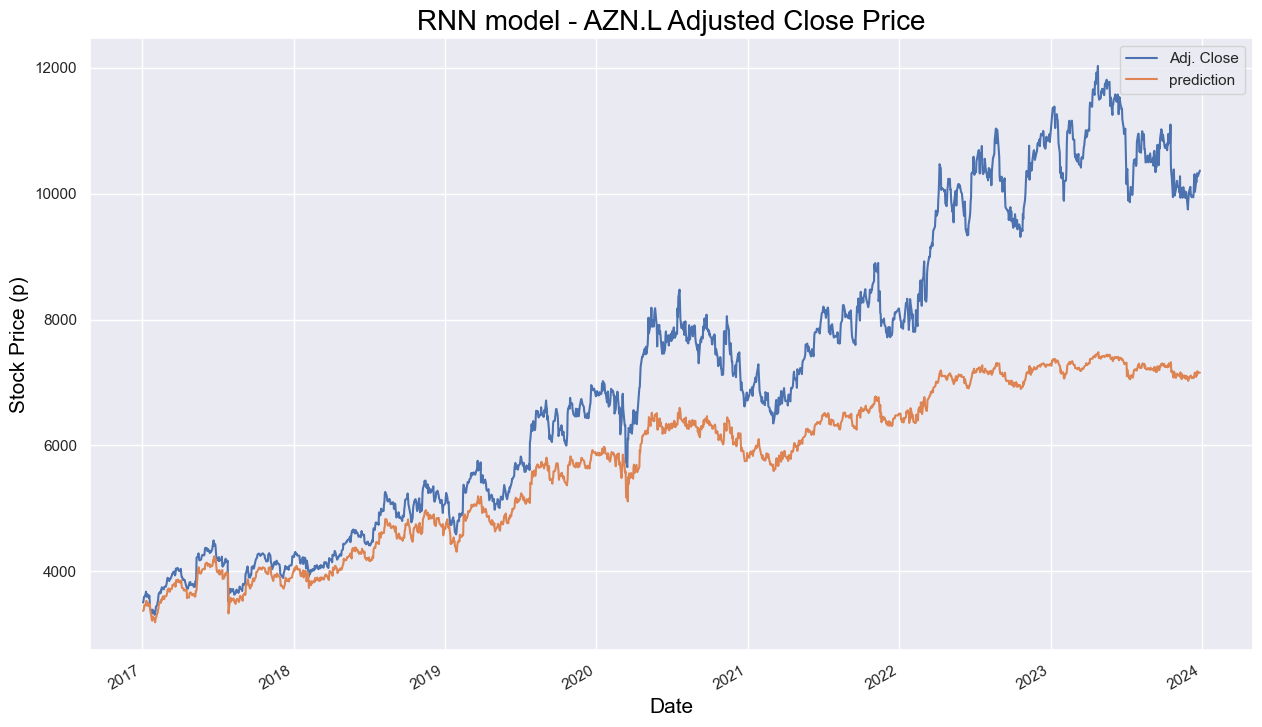

In [132]:
title_txt = 'RNN model - AZN.L Adjusted Close Price'

actual_pred_plot(rnn_predictions)

In [133]:
def LSTM_model(X_train, y_train, X_test, sc):  
    """
    Create LSTM model trained on X_train and y_train
    and make predictions on the X_test data

    :param X_train: input features for training the model
    :param y_train: output features for training the model
    :param X_test:  test data to make predictions on
    :param sc: instantiated MinMaxScaler object fit to the training data

    :returns: trained model and array of predicted prices to original scale
    """
   
    # The LSTM architecture
    my_LSTM_model = Sequential()
    # First LSTM layer 
    my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    # Second LSTM layer 
    my_LSTM_model.add(LSTM(units=50, activation='tanh'))
    # Dropout regularisation
    my_LSTM_model.add(Dropout(0.2))
    # The output layer
    my_LSTM_model.add(Dense(units=2)) 

    # Compiling the LSTM
    my_LSTM_model.compile(optimizer='adam',loss='mean_squared_error')

    # Fitting the LSTM to the training set
    my_LSTM_model.fit(X_train,y_train,epochs=200,batch_size=150, verbose=0)

    # Make Predictions using the test set
    LSTM_predictions = my_LSTM_model.predict(X_test)
    # Apply the MinMaxScaler to convert the scaled predictions to the original scale
    LSTM_predictions = sc.inverse_transform(LSTM_predictions)

    return my_LSTM_model, LSTM_predictions

my_LSTM_model, LSTM_predictions = LSTM_model(X_train, y_train, X_test, sc)
LSTM_predictions[1:10]

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


array([[3493.134 , 3487.8691],
       [3505.144 , 3499.6436],
       [3532.1082, 3526.0063],
       [3555.4707, 3549.0168],
       [3584.4172, 3577.5376],
       [3617.9072, 3610.5168],
       [3622.3687, 3615.239 ],
       [3612.479 , 3605.7888],
       [3613.7566, 3606.9949]], dtype=float32)

MSE score: 1548309.0


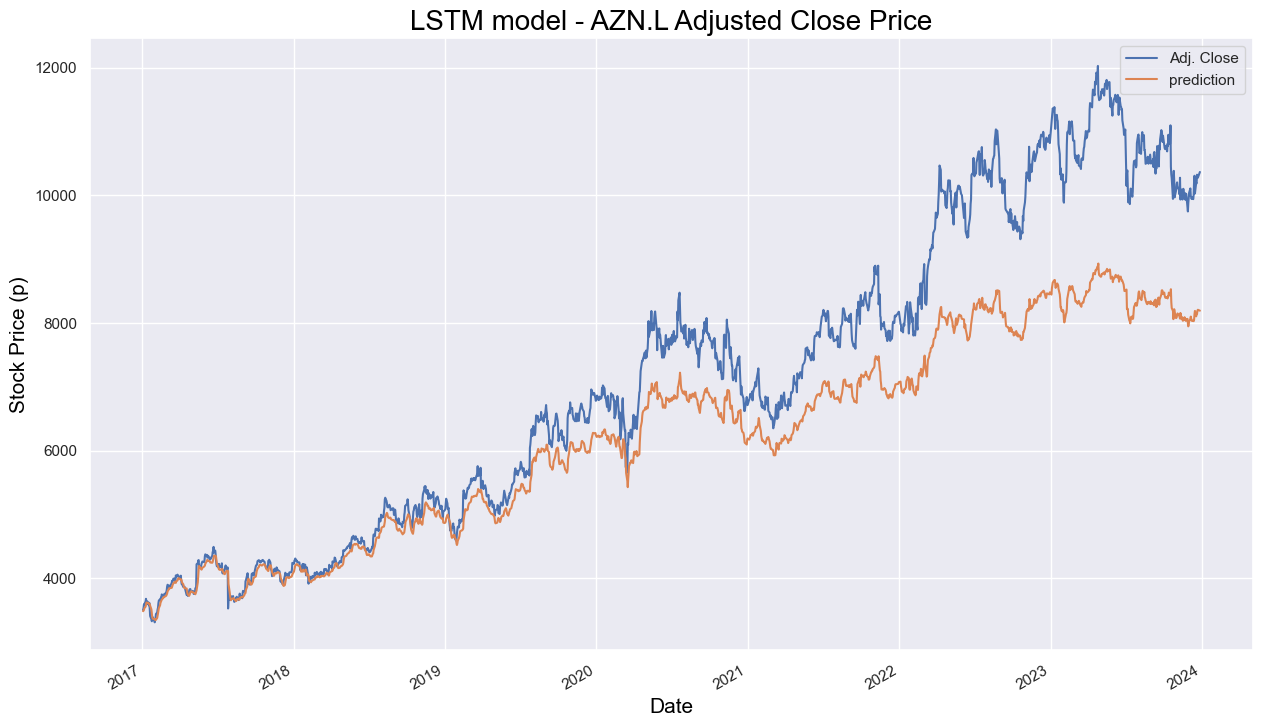

In [134]:
title_txt = 'LSTM model - AZN.L Adjusted Close Price'  

actual_pred_plot(LSTM_predictions)

In [135]:
def GRU_model(X_train, y_train, X_test, sc):  
    '''
    Create GRU model trained on X_train and y_train
    and make predictions on the X_test data

    :param X_train: input features for training the model
    :param y_train: predictions on training data
    :param X_test:  test data to make predictions on
    :param sc: instantiated MinMaxScaler object fit to the training data

    :returns: trained model and array of predicted prices to original scale
    '''

    # The GRU architecture
    my_GRU_model = Sequential()
    # First GRU layer with Dropout regularisation
    my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_GRU_model.add(Dropout(0.2))
    # Second GRU layer with Dropout regularisation
    my_GRU_model.add(GRU(units=50, return_sequences=True, activation='tanh'))
    my_GRU_model.add(Dropout(0.2))
    # Third GRU layer with Dropout regularisation
    my_GRU_model.add(GRU(units=50, return_sequences=True, activation='tanh'))
    my_GRU_model.add(Dropout(0.2))
    # Fourth GRU layer with Dropout regularisation
    my_GRU_model.add(GRU(units=50, activation='tanh'))
    my_GRU_model.add(Dropout(0.2))

    # The output layer
    my_GRU_model.add(Dense(units=2))

    # Compiling the GRU model
    my_GRU_model.compile(optimizer='adam',loss='mean_squared_error')

    # Fitting to the training set
    my_GRU_model.fit(X_train,y_train,epochs=200,batch_size=150, verbose=0)

    # Make Predictions using the test set
    GRU_predictions = my_GRU_model.predict(X_test)
    # Apply the MinMaxScaler to convert the scaled predictions to the original scale
    GRU_predictions = sc.inverse_transform(GRU_predictions)

    return my_GRU_model, GRU_predictions

my_GRU_model, GRU_predictions = GRU_model(X_train, y_train, X_test, sc)
GRU_predictions[1:10]

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


array([[3516.4924, 3516.8203],
       [3533.5532, 3533.7388],
       [3574.9634, 3574.9058],
       [3596.3083, 3596.2954],
       [3624.2246, 3624.0125],
       [3662.2488, 3661.6995],
       [3644.4814, 3644.1172],
       [3615.9895, 3615.5752],
       [3630.6729, 3629.8232]], dtype=float32)

MSE score: 1303142.6


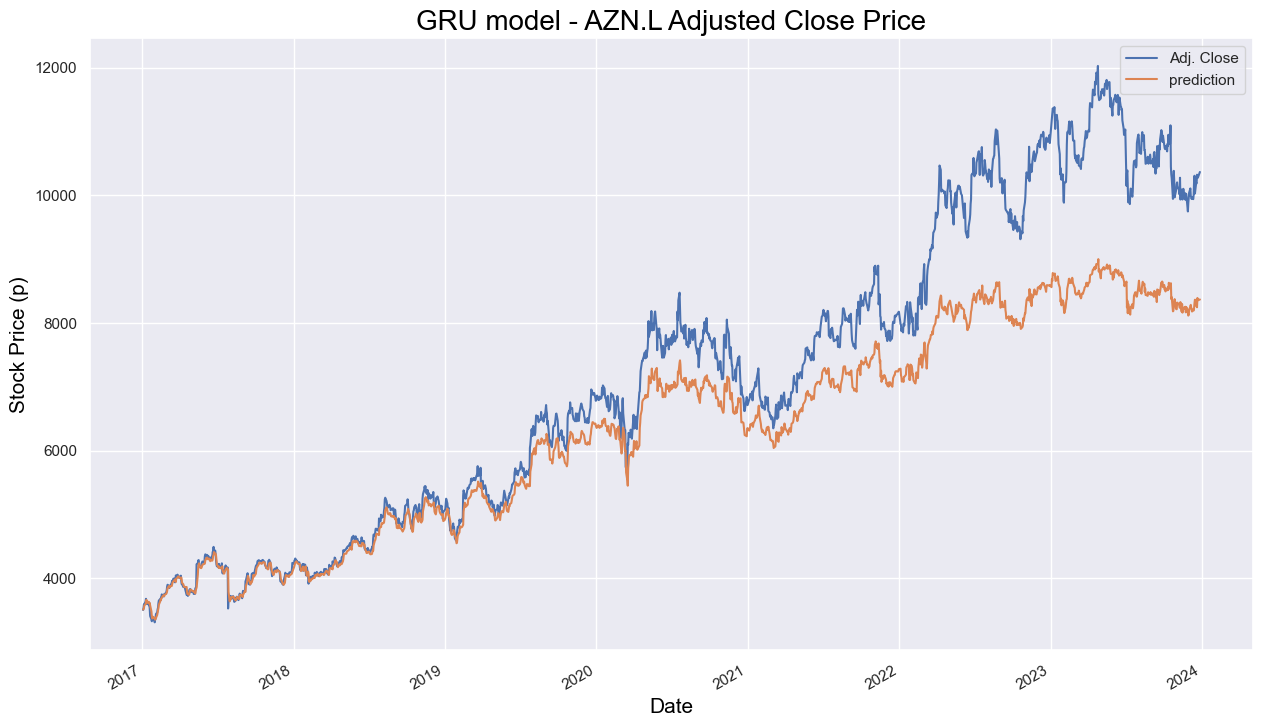

In [136]:
title_txt = 'GRU model - AZN.L Adjusted Close Price'   

actual_pred_plot(GRU_predictions) 